# gwexpy TimeSeries New Features Tutorial

This notebook introduces the new methods added to the `TimeSeries` class in `gwexpy`, an extension of `gwpy`, and explains how to use them.

`gwexpy` maintains high compatibility with GWpy while significantly enhancing signal processing, statistical analysis, and interoperability with other libraries.

## Table of Contents
1. Environment Setup
2. Signal Processing and Demodulation (Hilbert, Phase, Demodulation)
3. Spectral Analysis and Correlation (FFT, Transfer Function, xcorr)
4. Hilbert-Huang Transform (HHT)
5. Statistics and Preprocessing (Impute, Standardize, ARIMA, Hurst, Rolling)
6. Resampling and Reindexing (asfreq, resample)
7. Function Fitting (fit)
8. Interoperability (Pandas, Xarray, Torch, and more)

## 1. Environment Setup

First, we import the necessary libraries and generate sample data for demonstration.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.noise.wave import chirp, exponential, gaussian, sine
from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries

# Generate sample data (5 seconds of data sampled at 100Hz)
fs = 100
duration = 5.0
# Restore 't' for compatibility with downstream cells if they use it
t = np.arange(0, duration, 1 / fs)

# Sensor 1: 10Hz sine wave + noise
s1 = sine(duration=duration, sample_rate=fs, frequency=10, amplitude=1.0)
n1 = gaussian(duration=duration, sample_rate=fs, std=0.2)
ts1 = s1 + n1
ts1.name = "Sensor 1"
ts1.override_unit("V")

# Sensor 2: Chirp signal (frequency changes over time: 5Hz -> 25Hz) + exponential amplification
s2 = chirp(duration=duration, sample_rate=fs, f0=5, f1=25, t1=duration)
env = exponential(
    duration=duration, sample_rate=fs, tau=2.0, decay=False, amplitude=0.2
)
ts2 = s2 * env
ts2.name = "Chirp Signal"
ts2.override_unit("V")

## 2. Signal Processing and Demodulation

`gwexpy` integrates Hilbert transforms, envelope calculations, instantaneous frequency computation, and demodulation functions like lock-in amplifiers.

### Hilbert Transform and Envelope

Use `hilbert` and `envelope`.

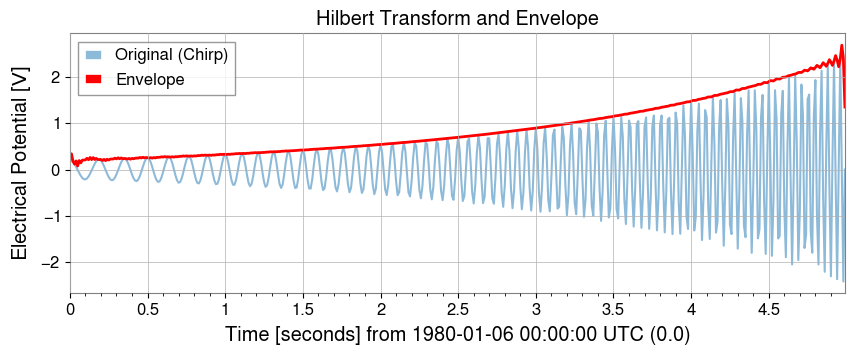

In [2]:
# Calculate the analytic signal
ts_analytic = ts2.hilbert()
# Calculate the envelope
ts_env = ts2.envelope()

plot = Plot(ts2, ts_env, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label("Original (Chirp)")
ax.get_lines()[0].set_alpha(0.5)
ax.get_lines()[1].set_label("Envelope")
ax.get_lines()[1].set_color("red")
ax.get_lines()[1].set_linewidth(2)
ax.legend()
ax.set_title("Hilbert Transform and Envelope")
plt.show()

### Instantaneous Phase and Instantaneous Frequency

Use `instantaneous_phase` and `instantaneous_frequency`. You can specify phase unwrapping (`unwrap`) and degree units (`deg`).

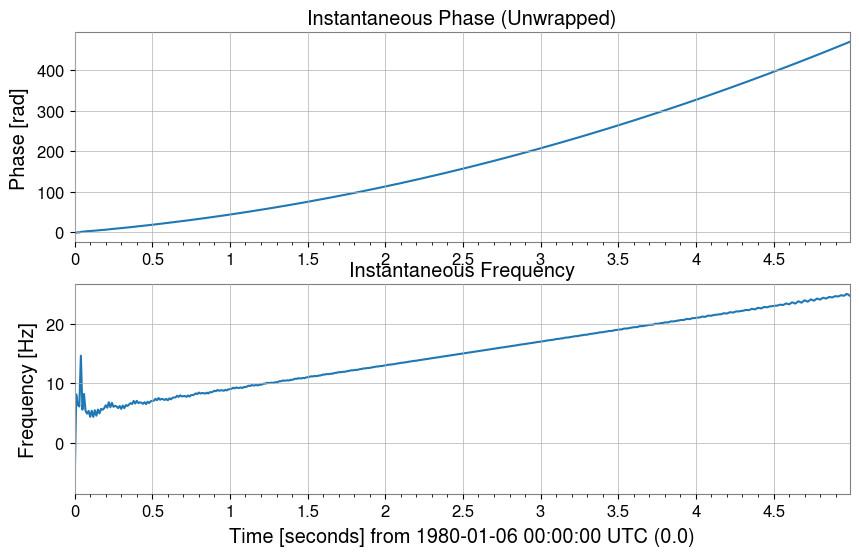

In [3]:
# Instantaneous phase (unwrap=True to remove phase jumps)
phase_rad = ts2.instantaneous_phase(unwrap=True)
phase_deg = ts2.instantaneous_phase(deg=True, unwrap=True)

# Instantaneous frequency
freq = ts2.instantaneous_frequency()

plot = Plot(phase_rad, freq, separate=True, sharex=True, figsize=(10, 6))
ax = plot.axes
ax[0].set_ylabel("Phase [rad]")
ax[0].set_title("Instantaneous Phase (Unwrapped)")
ax[1].set_ylabel("Frequency [Hz]")
ax[1].set_title("Instantaneous Frequency")
plt.show()

### Mixing and Demodulation (Mix-down, Baseband, Lock-in)

Functions for extracting specific frequency components or bringing them down to baseband.

TimeSeries([1.07311488, 1.06034355, 1.01109634, 1.01781907,
            0.93131164, 1.02528884, 1.03480937, 1.016365  ,
            1.04893062, 0.99547661, 1.05348659, 0.95691516,
            1.02574794, 1.03344934, 1.0540728 , 1.03929426,
            0.92597349, 0.97710877, 1.05543266, 0.9733485 ,
            1.03715212, 1.08016956, 1.03255853, 1.15952468,
            1.25055081, 1.06050871, 1.06886791, 1.05521341,
            1.03863405, 0.79817485, 1.1453174 , 1.17233586,
            0.96094702, 1.00609577, 0.94868913, 0.89945745,
            1.01527361, 0.99954323, 0.86674081, 0.91965864,
            0.95972681, 0.91424393, 0.94174077, 0.92435144,
            1.11105891, 1.02226989, 0.92864471, 0.95288753,
            1.07116221, 1.01336055]
           unit: V,
           t0: 0.0 s,
           dt: 0.1 s,
           name: Sensor 1,
           channel: None)


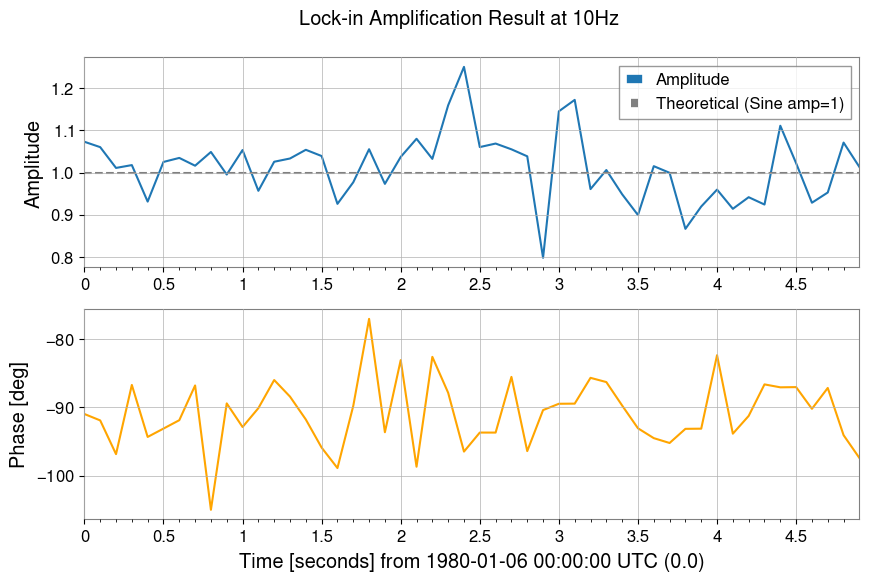

In [4]:
# 1. mix_down: Demodulate at a specific frequency f0 (becomes a complex signal)
ts_mixed = ts1.mix_down(f0=10)

# 2. baseband: Execute demodulation + lowpass + resampling in one step
ts_base = ts1.baseband(f0=10, lowpass=5, output_rate=20)

# 3. lock_in: Lock-in detection (extract amplitude and phase)
amp, ph = ts1.lock_in(f0=10, stride=0.1)  # Output average every 0.1 seconds
res_complex = ts1.lock_in(
    f0=10, stride=0.1, output="complex"
)  # Output as complex numbers

print(amp)

plot = Plot(amp, ph, separate=True, sharex=True, figsize=(10, 6))
ax = plot.axes
ax[0].get_lines()[0].set_label("Amplitude")
ax[0].axhline(1.0, color="gray", linestyle="--", label="Theoretical (Sine amp=1)")
ax[0].set_ylabel("Amplitude")
ax[0].legend()
ax[1].get_lines()[0].set_color("orange")
ax[1].get_lines()[0].set_label("Phase [deg]")
ax[1].set_ylabel("Phase [deg]")
plot.figure.suptitle("Lock-in Amplification Result at 10Hz")
plt.show()

## 3. Spectral Analysis and CorrelationWhile inheriting GWpy's functionality, `mode="transient"` FFT for transient signals and transfer function calculation via direct FFT ratio have been added.

### Extended FFTUsing `mode="transient"` enables zero-padding, adjustment to fast lengths, and individual left/right padding specifications.

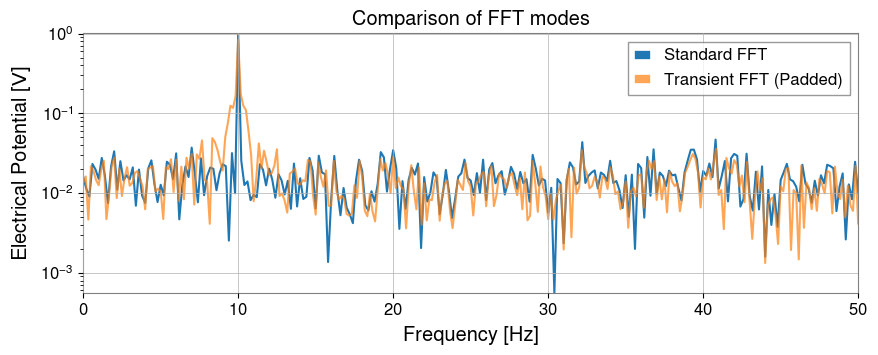

In [5]:
# Standard FFT (GWpy compatible)
fs_gwpy = ts1.fft()

# Transient mode:
# Specify padding amount with pad_left/right。nfft_mode="next_fast_len" でAdjust to computationally efficient length。
fs_trans = ts1.fft(
    mode="transient", pad_left=0.5, pad_right=0.5, nfft_mode="next_fast_len"
)

plot = Plot(fs_gwpy.abs(), fs_trans.abs(), yscale="log", xlim=(0, 50), figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label("Standard FFT")
ax.get_lines()[1].set_label("Transient FFT (Padded)")
ax.get_lines()[1].set_alpha(0.7)
ax.legend()
ax.set_title("Comparison of FFT modes")
plt.show()

### Transfer Function and Cross-Correlation (xcorr)With `transfer_function`, you can choose not only the Welch method (`mode="steady"`) but also direct FFT ratio (`mode="transient"`).

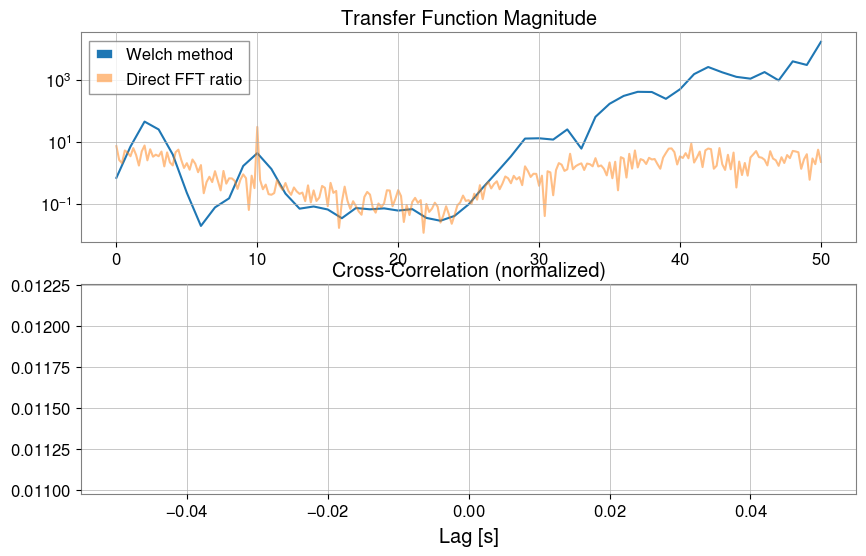

In [6]:
# Calculate transfer function (transfer function of Chirp Signal with respect to Sensor 1)
tf_welch = ts2.transfer_function(ts1, fftlength=1)
tf_fft = ts2.transfer_function(
    ts1, mode="transient"
)  # Full-span FFT ratio (useful for transient response analysis)

# Cross-correlation (xcorr)
corr = ts1.xcorr(ts2, maxlag=0.5, normalize="coeff")

plot = Plot(figsize=(10, 6))
ax1 = plot.add_subplot(2, 1, 1)
ax1.semilogy(tf_welch.frequencies, np.abs(tf_welch), label="Welch method")
ax1.semilogy(tf_fft.frequencies, np.abs(tf_fft), label="Direct FFT ratio", alpha=0.5)
ax1.set_title("Transfer Function Magnitude")
ax1.legend()

ax2 = plot.add_subplot(2, 1, 2)
lag = corr.times.value - corr.t0.value
ax2.plot(lag, corr)
ax2.set_title("Cross-Correlation (normalized)")
ax2.set_xlabel("Lag [s]")
plt.show()

### STLT (Short-Time Laplace Transform)STLT (Short-Time Laplace Transform) is a transform for extracting local structures that change over time in a signal.In `gwexpy`, the STLT result is a 3D transform with axes **(time × sigma × frequency)**, represented by `TimePlaneTransform` / `LaplaceGram`.Below is an example of calculating STLT using the `stlt` method and extracting a slice (`Plane2D`) at a specific time.This example also demonstrates specifying `frequencies` (Hz) to evaluate STLT at arbitrary frequency points.

In [7]:
# Data preparation (for demonstration)
import numpy as np

from gwexpy.plot import Plot

t = np.linspace(0, 10, 1000)
data = TimeSeries(np.sin(2 * np.pi * 1 * t), times=t * u.s, unit="V", name="Demo Data")

# STLT
# stride: time step, window: analysis window length
freqs = np.array([0.5, 1.0, 1.5])  # Hz
stlt_result = data.stlt(stride="0.5s", window="2s", frequencies=freqs)

print(f"Kind: {stlt_result.kind}")
print(f"Shape: {stlt_result.shape} (Time x Sigma x Frequency)")
print(f"Time Axis: {len(stlt_result.times)} steps")
print(f"Sigma Axis: {len(stlt_result.axis1.index)} bins")
print(f"Frequency Axis: {len(stlt_result.axis2.index)} bins")

# Extract plane at specific time (t=5.0s)
plane_at_5s = stlt_result.at_time(5.0 * u.s)
print(f"Plane at 5.0s shape: {plane_at_5s.shape}")

# Plane2D Confirm behavior as Plane2D
print(f"Axis 1: {plane_at_5s.axis1.name}")
print(f"Axis 2: {plane_at_5s.axis2.name}")

Kind: stlt
Shape: (17, 1, 3) (Time x Sigma x Frequency)
Time Axis: 17 steps
Sigma Axis: 1 bins
Frequency Axis: 3 bins
Plane at 5.0s shape: (1, 3)
Axis 1: sigma
Axis 2: frequency


## 4. Hilbert-Huang Transform (HHT)Hilbert-Huang Transform (HHT) functionality for nonlinear and non-stationary signal analysis.Combines Empirical Mode Decomposition (EMD) and Hilbert spectral analysis.

Extracted IMFs: ['IMF1', 'IMF2', 'IMF3', 'residual']


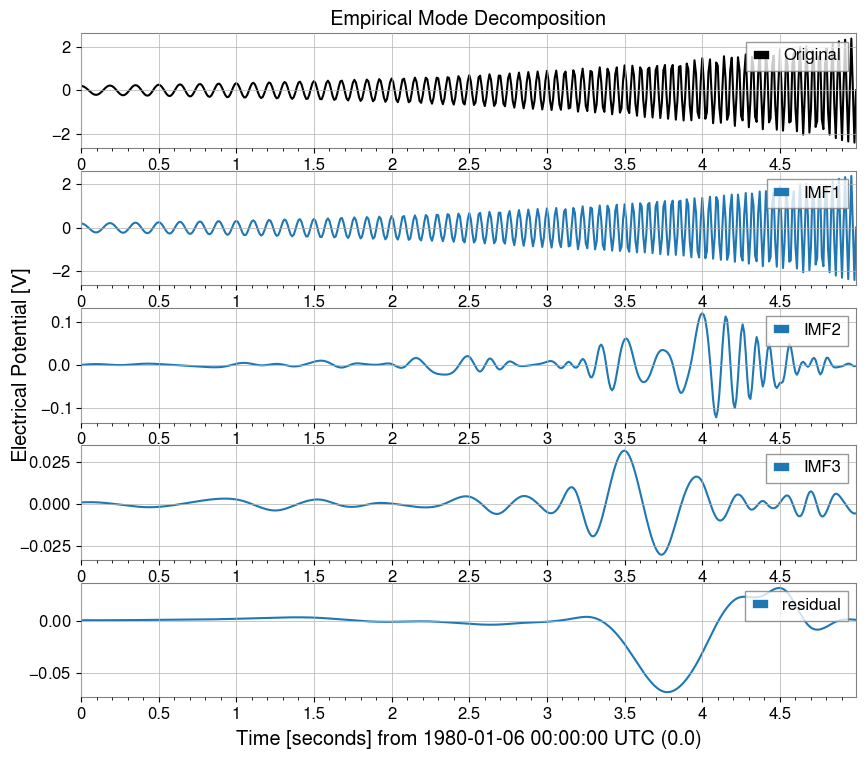

In [8]:
# HHT (Hilbert-Huang Transform)
# Execute Empirical Mode Decomposition (EMD) and extract IMFs (Intrinsic Mode Functions)
# Note意: Requires PyEMD (EMD-signal) : `pip install EMD-signal`

try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    # EMDExecute EMD (returns dictionary)
    # method="emd" (standard EMD) or "eemd" (Ensemble EMD)
    # Here we use ts2 (example with chirp signal)
    imfs = ts2.emd(method="emd", max_imf=3)

    print(f"Extracted IMFs: {list(imfs.keys())}")

    # Plot IMFs
    sorted_keys = sorted(
        [k for k in imfs.keys() if k.startswith("IMF")], key=lambda x: int(x[3:])
    )
    if "residual" in imfs:
        sorted_keys.append("residual")

    # gwexpy.plot.Plot for batch plotting
    plot_data = [ts2] + [imfs[k] for k in sorted_keys]
    plot = Plot(*plot_data, separate=True, sharex=True, figsize=(10, 8))

    # Original settings
    ax0 = plot.axes[0]
    ax0.get_lines()[0].set_label("Original")
    ax0.get_lines()[0].set_color("black")
    ax0.legend(loc="upper right")
    ax0.set_title("Empirical Mode Decomposition")

    # IMF settings
    for i, key in enumerate(sorted_keys):
        ax = plot.axes[i + 1]
        ax.get_lines()[0].set_label(key)
        ax.legend(loc="upper right")

    plt.show()

except ImportError:
    print("EMD-signal not installed. Skipping HHT demo.")
except Exception as e:
    print(f"HHT Error: {e}")

## 5. Statistics and PreprocessingMissing value imputation, standardization, ARIMA models, Hurst exponent, and rolling statistics are available as TimeSeries methods.

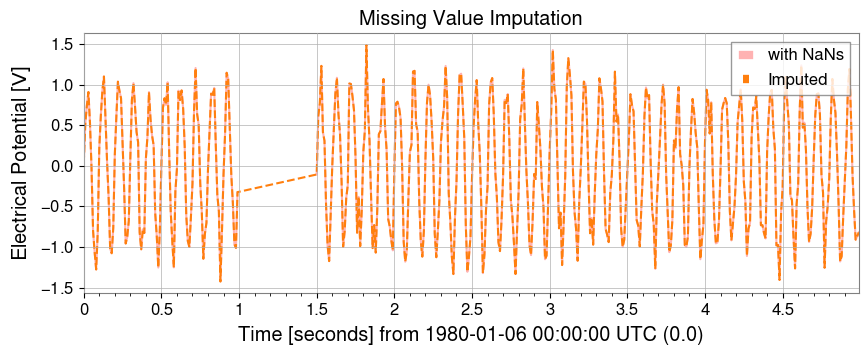

In [9]:
# Test data with missing values
ts_nan = ts1.copy()
ts_nan.value[100:150] = np.nan

# 1. impute: Missing value imputation (interpolation, etc.)
ts_imputed = ts_nan.impute(method="interpolate")

# 2. standardize: Standardization (z-score, robust, etc.)
ts_z = ts1.standardize(method="zscore")
ts_robust = ts1.standardize(method="zscore", robust=True)  # Use Median/IQR

plot = Plot(ts_nan, ts_imputed, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label("with NaNs")
ax.get_lines()[0].set_color("red")
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[1].set_label("Imputed")
ax.get_lines()[1].set_linestyle("--")
ax.legend()
ax.set_title("Missing Value Imputation")
plt.show()

### Peak Detection (Find Peaks)Wraps `scipy.signal.find_peaks` to detect peaks in time series data.

Found 9 peaks
First 5 peaks: TimeSeries([0.25680508, 0.32974425, 0.44255219, 0.58570943,
            0.81881855]
           unit: V,
           t0: 0.5 s,
           dt: 0.5 s,
           name: Chirp Signal_peaks,
           channel: None)


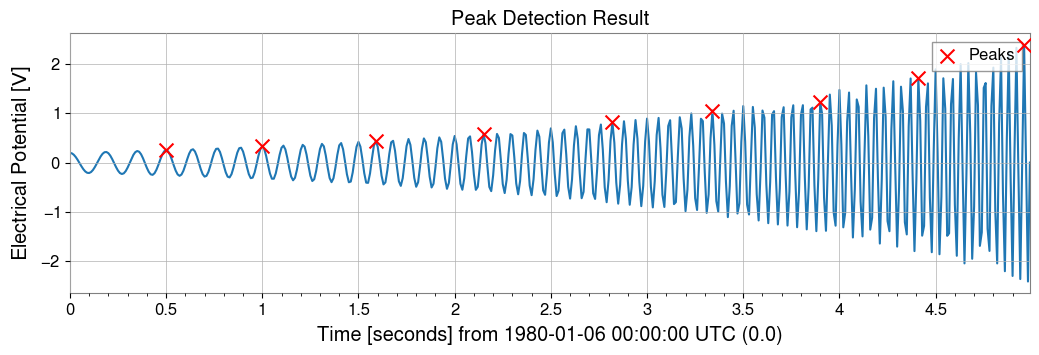

In [10]:
# Peak Detection (Find Peaks)
# height, threshold, distance, prominence, width such asCan specify parameters such as
# Can also specify thresholds with units

# ts2 (Chirp + Sine) Find peaks in
peaks, props = ts2.find_peaks(height=0.0, distance=50)

print(f"Found {len(peaks)} peaks")
if len(peaks) > 0:
    print("First 5 peaks:", peaks[:5])

# Plot
plot = ts2.plot(figsize=(12, 4))
ax = plot.gca()
ax.scatter(
    peaks.times.value,
    peaks.value,
    marker="x",
    color="red",
    s=100,
    label="Peaks",
    zorder=10,
)
ax.legend(loc="upper right")
ax.set_title("Peak Detection Result")
plt.show()

### ARIMA Model and Hurst ExponentNote: These features require libraries such as `statsmodels` and `hurst`.

In [11]:
try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    # 3. fit_arima: ARIMA(1,0,0) fitting and forecasting
    model = ts1.fit_arima(order=(1, 0, 0))
    resid = model.residuals()
    forecast, conf = model.forecast(steps=30)

    plot = Plot(ts1.tail(100), forecast, figsize=(10, 4))
    ax = plot.gca()
    ax.get_lines()[0].set_label("Measured")
    ax.get_lines()[1].set_label("Forecast")
    ax.get_lines()[1].set_color("orange")

    # Fill between
    ax.fill_between(
        conf["lower"].times.value,
        conf["lower"].value,
        conf["upper"].value,
        alpha=0.2,
        color="orange",
    )

    ax.set_title("ARIMA(1,0,0) Fit & Forecast")
    ax.legend()
    plt.show()
except Exception as e:
    print(f"ARIMA skipping: {e}")

try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    # 4. hurst / local_hurst: Hurst exponent (indicator of long-range correlation)
    h_val = ts1.hurst()
    h_detail = ts1.hurst(return_details=True)  # With detailed information
    h_local = ts1.local_hurst(window=1.0)  # Evolution with 1-second window

    plot = Plot(h_local, figsize=(10, 4))
    ax = plot.gca()
    ax.get_lines()[0].set_label("Local Hurst")
    ax.axhline(h_val, color="red", linestyle="--", label=f"Global H={h_val:.2f}")
    ax.set_ylim(0, 0.2)
    ax.set_title("Hurst Exponent Analysis")
    ax.legend()
    plt.show()
except Exception as e:
    print(f"Hurst skipping: {e}")

ARIMA skipping: statsmodels is required for ARIMA. `pip install statsmodels`
Hurst skipping: No Hurst backend found. Install hurst, hurst-exponent, or exp-hurst.


### Rolling StatisticsSimilar to Pandas, `rolling_mean`, `std`, `median`, `min`, `max` are available.

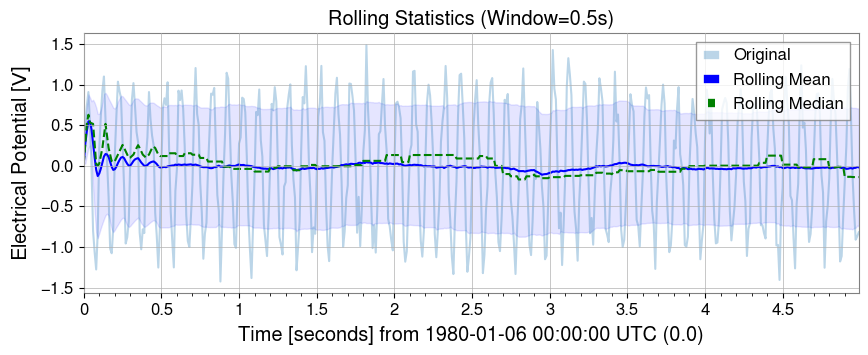

In [12]:
rw = 0.5 * u.s  # 0.5 second window
rmean = ts1.rolling_mean(rw)
rstd = ts1.rolling_std(rw)
rmed = ts1.rolling_median(rw)
rmin = ts1.rolling_min(rw)
rmax = ts1.rolling_max(rw)

plot = Plot(ts1, rmean, rmed, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label("Original")
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[1].set_label("Rolling Mean")
ax.get_lines()[1].set_color("blue")
ax.get_lines()[2].set_label("Rolling Median")
ax.get_lines()[2].set_color("green")
ax.get_lines()[2].set_linestyle("--")
ax.fill_between(
    rmean.times.value,
    rmean.value - rstd.value,
    rmean.value + rstd.value,
    alpha=0.1,
    color="blue",
)
ax.legend()
ax.set_title("Rolling Statistics (Window=0.5s)")
plt.show()

## 6. Resampling and ReindexingThe `asfreq` method allows assignment to a fixed grid, and the `resample` method enables "time bin aggregation".

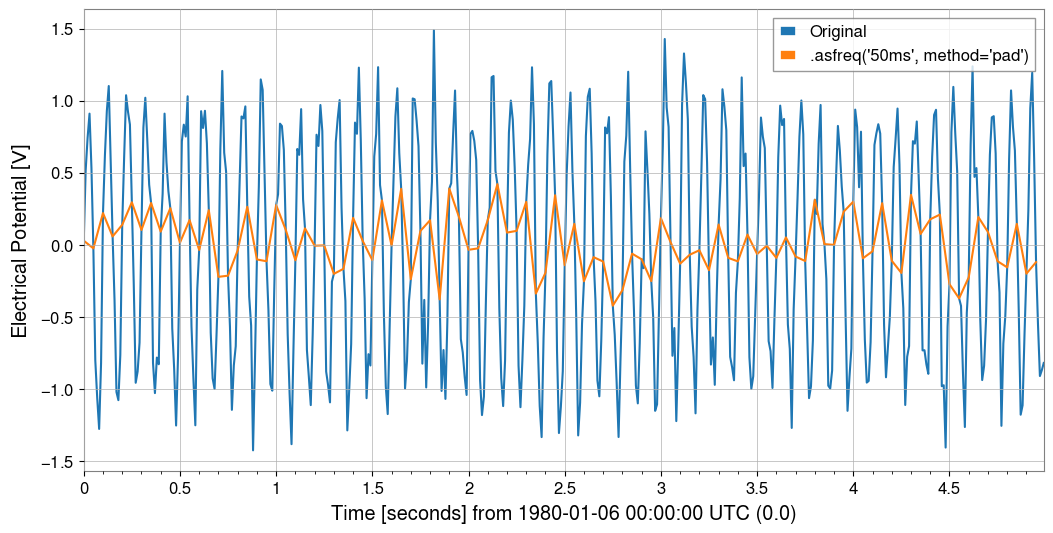

In [13]:
# 1. asfreq: Reindex with Pandas-like naming conventions ('50ms' など)
ts_reindexed = ts1.asfreq("50ms", method="pad")
Plot(ts1, ts_reindexed)
plt.legend(["Original", ".asfreq('50ms', method='pad')"])

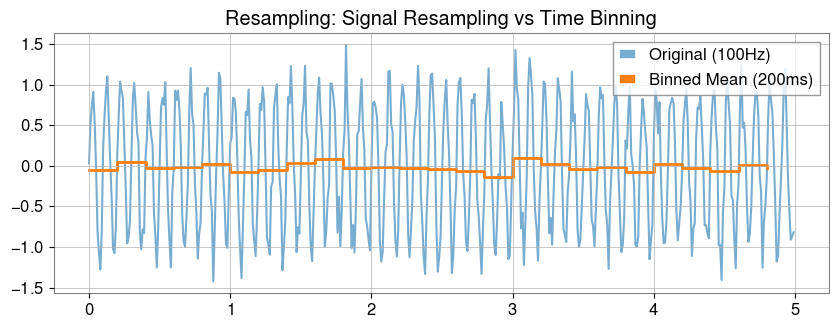

In [14]:
# 2. resample:
# If you specify a number (10Hz) , signal processing resampling (GWpy standard)
ts_sig = ts1.resample(10)
# If you specify a string ('200ms') , statistics for each time bin (new feature)
ts_binned = ts1.resample("200ms")  # Default is mean

# Plot doesn't have a direct 'step' method equivalent in args, so we use ax.step or pass to plot
# However, kwarg 'drawstyle'='steps-post' works in plot()? gwpy Plot wraps matplotlib.
# Let's assume we can modify axes after creation or use standard plot for simplicity if appropriate, but step is specific.
# Better strategy: Create Plot instance, then use ax.step
plot = Plot(figsize=(10, 4))
ax = plot.gca()
ax.plot(ts1, alpha=0.6, label="Original (100Hz)")
ax.step(
    ts_binned.times,
    ts_binned.value,
    where="post",
    label="Binned Mean (200ms)",
    linewidth=2,
)
ax.legend()
ax.set_title("Resampling: Signal Resampling vs Time Binning")
plt.show()

## 7. Function Fitting`gwexpy` provides powerful fitting functionality based on `iminuit`. To avoid polluting GWpy's original classes, the `.fit()` method is opt-in.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.0005703 (χ²/ndof = 0.0)  │              Nfcn = 324              │
│ EDM = 0.000176 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

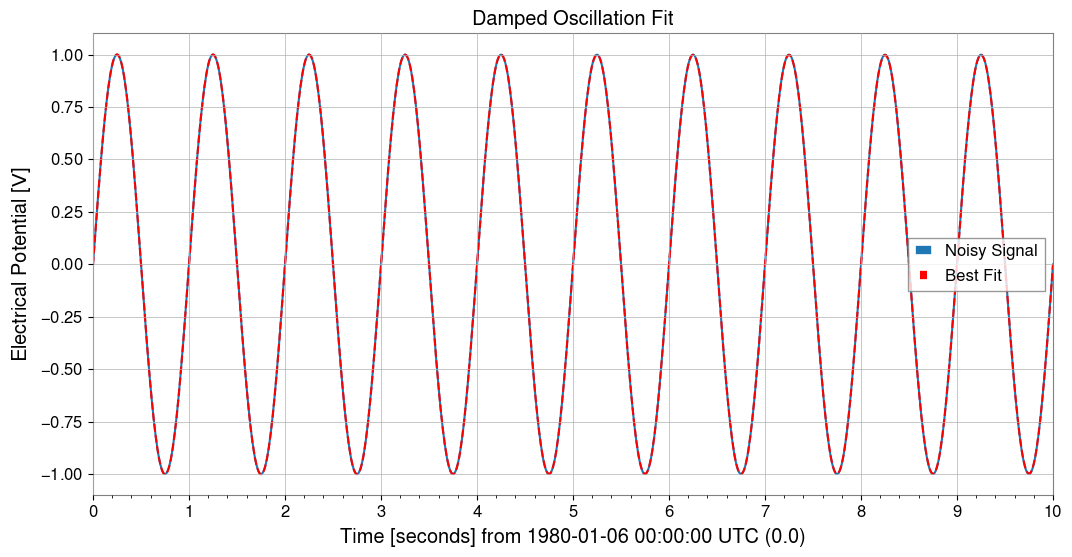

In [15]:
from gwexpy.fitting.models import damped_oscillation

# Fit with damped oscillation model (pass function directly)
# Initial values: A=0.5, tau=0.5, f=15, phi=0
result = data.fit(damped_oscillation, A=0.5, tau=0.5, f=15, phi=0)

# Display result (iminuit format)
print(result)

# Get best-fit curve
# Note: x_data is the time array corresponding to data points
x_data = data.times.value
best_fit = result.model(x_data)

# Plot
plot = data.plot(label="Noisy Signal")
ax = plot.gca()
ax.plot(data.times, best_fit, label="Best Fit", color="red", linestyle="--")
ax.legend()
ax.set_title("Damped Oscillation Fit")
plt.show()

## 8. InteroperabilityInterconversion with major data science and machine learning libraries is very smooth.

In [16]:
# Pandas & Xarray
try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    df = ts1.to_pandas(index="datetime")
    ts_p = TimeSeries.from_pandas(df)
    print("Pandas interop OK")
    display(df)
except ImportError:
    pass

try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    xr = ts1.to_xarray()
    ts_xr = TimeSeries.from_xarray(xr)
    print("Xarray interop OK")
    print(xr)
except ImportError:
    pass

Pandas interop OK


time_utc
1980-01-06 00:00:19+00:00           0.029290
1980-01-06 00:00:19.010000+00:00    0.518183
1980-01-06 00:00:19.020000+00:00    0.742906
1980-01-06 00:00:19.030000+00:00    0.910232
1980-01-06 00:00:19.040000+00:00    0.533494
                                      ...   
1980-01-06 00:00:23.950000+00:00   -0.119294
1980-01-06 00:00:23.960000+00:00   -0.549101
1980-01-06 00:00:23.970000+00:00   -0.909165
1980-01-06 00:00:23.980000+00:00   -0.868241
1980-01-06 00:00:23.990000+00:00   -0.818474
Name: Sensor 1, Length: 500, dtype: float64

Xarray interop OK
<xarray.DataArray 'Sensor 1' (time: 500)> Size: 4kB
array([ 0.02929044,  0.51818327,  0.74290639, ..., -0.90916539,
       -0.86824139, -0.81847371], shape=(500,))
Coordinates:
  * time     (time) datetime64[us] 4kB 1980-01-06T00:00:19 ... 1980-01-06T00:...
Attributes:
    unit:        V
    name:        Sensor 1
    channel:     None
    epoch:       0.0
    time_coord:  datetime


In [17]:
# SQLite (serialized storage)
import sqlite3

with sqlite3.connect(":memory:") as conn:
    ts1.to_sqlite(conn, series_id="my_sensor")
    ts_sql = TimeSeries.from_sqlite(conn, series_id="my_sensor")
    print(f"SQLite interop OK: {ts_sql.name}")
    display(conn)

SQLite interop OK: my_sensor


In [18]:
# Deep Learning (Torch)
try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    import torch

    _ = torch
    t_torch = ts1.to_torch()
    ts_f_torch = TimeSeries.from_torch(t_torch, t0=ts1.t0, dt=ts1.dt)
    print(f"Torch interop OK (Shape: {t_torch.shape})")
    display(t_torch)
except ImportError:
    pass

In [19]:
# Deep Learning (TensorFlow)
try:
    import os
    import warnings

    os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "3")
    warnings.filterwarnings(
        "ignore", category=UserWarning, module=r"google\.protobuf\..*"
    )
    warnings.filterwarnings(
        "ignore", category=UserWarning, message=r"Protobuf gencode version.*"
    )
    import tensorflow as tf

    _ = tf
    t_tf = ts1.to_tensorflow()
    ts_f_tf = TimeSeries.from_tensorflow(t_tf, t0=ts1.t0, dt=ts1.dt)
    print("TensorFlow interop OK")
    display(t_tf)
except ImportError:
    pass

In [20]:
# ObsPy (seismic waveform and time series analysis)
try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    import obspy

    _ = obspy
    tr = ts1.to_obspy()
    ts_f_obspy = TimeSeries.from_obspy(tr)
    print(f"ObsPy interop OK: {tr.id}")
    display(tr)
except ImportError:
    pass

## Summary

In this tutorial, we have covered the key enhancements in `gwexpy.TimeSeries`:

- **Signal Processing**: Hilbert transform, demodulation, and extended FFT modes.
- **Statistics**: Advanced correlation methods (MIC, Distance Correlation) and ARIMA modeling.
- **Data Cleaning**: Missing value imputation and standardization.
- **Interoperability**: Seamless conversion to/from Pandas, Xarray, PyTorch, TensorFlow, and ObsPy.

### Next Steps

- **Multichannel Data**: Learn about [TimeSeriesMatrix](matrix_timeseries.ipynb) for handling many channels simultaneously.
- **Spectral Analysis**: Explore [FrequencySeries](intro_frequencyseries.ipynb).
- **4D Fields**: Check out [ScalarField](field_scalar_intro.ipynb) for spacetime analysis.